# Actividad práctica: Predicción de series de tiempo

En esta tarea se pide entrenar y evaluar un predictor para la serie de tiempo Mackey-Glass. Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = 0.2 \frac{ y(t-\tau)}{1 + y(t-\tau)^{10}} - 0.1 y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

- Siga las instrucciones en este notebook para resolver el problema de predicción
- Conteste las preguntas que se encuentran en este enunciado
- Finalmente envíe su notebook con los resultados y respuestas a phuijse@inf.uach.cl
- No olvide cambiar el título para reflejar los integrantes de su grupo

In [1]:
import numpy as np

%matplotlib notebook
from IPython.display import display, Audio, HTML
import matplotlib.pylab as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import soundfile as sf
import scipy.signal
%matplotlib notebook
from matplotlib import animation, patches
import pandas
from pandas import DataFrame

from style import *

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)
L_list = [5,10,20,30]
muList = np.logspace(-2, 0, num=20)
BList = np.linspace(0.8,1.0,num=20)

Cannot find path /home/phuijse/.jupyter/nbconfig/, rise configuration wasn't set


***

Use el código que se muestra a continuación para generar la serie de tiempo Mackey Glass

- Considere una razón señal a ruido (SNR) de 2.
- Considere $\tau=17$ (comportamiento debilmente caótico)

Se generaran 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar y los siguientes 500 puntos para hacer predicción

<IPython.core.display.Javascript object>


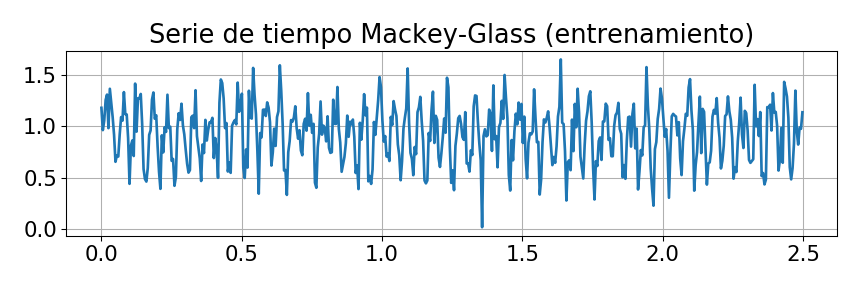

In [2]:
# número de observaciones (no modificar)
N = 1000
# Razón señal a ruido (2., 0.5)
SNR = 2.
# constantes de la ecuación diferencial (no modificar)
a, b = 0.1, 0.2
# comportamiento dinámico de Mackey-Glass (17, 30)
tauL = [17.,30.]
# paso de integración (no modificar)
dt = 0.05
# condición incial (no modificar)
y0 = 0.9
# largo temporal (no modificar)
tt = 5.
t = np.linspace(0, tt, num=N)

N_full, tau_full = int(N*tt/dt), int(tauL[0]/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))
# Gráfico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

***

1. Describa en detalle el algoritmo LMS indicando sus semejanzas y diferencias con el filtro de Wiener 
1. Partiendo del error instantaneo $J_n^s(\textbf{w}) = e_n^2$ derive la regla de actualización de pesos
1. La siguiente clase de *Python* predice y entrena un filtro LMS. Complete la línea que dice 

` self.w = ? `

con el valor correcto de actualización de peso del filtro LMS

In [3]:
class LMS_filter(object):
    
    def __init__(self, L, mu, normalized=True):
        self.L = L
        self.mu = mu
        self.w = np.zeros(shape=(L, ))
        self.normalized = normalized
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)
    
    def update(self, u, d):
        d_pred = self.predict(u)
        aux = self.L
        norm = 1.
        if self.normalized:
            norm = np.sum(u**2) + 1e-6
        self.w = self.w + 2*self.mu*(u -d_pred)*u/norm

***
## Predicción con algoritmo LMS

1. Entrene el predictor con el algoritmo normalized LMS usando el siguiente bloque de código
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\mu$ y $L$
    - Se recomienda hacer un barrido logarítmico en $\mu$ (por ejemplo `mu=np.logspace(-2, 0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¿Se sobreajuste el filtro a los datos de entrenamiento? 
    - ¿Se desestabiliza el filtro?
1. Indique que combinación obtiene menor MSE de prueba 
    - L=30, μ=1.000000, MSE Prueba=412.152927
***

1. Repita el experimento para $\tau = 30$ (comportamiento fuertemente caótico) 
    - Si/No se sobreajusta...
    - Si/No se desestabiliza...
    - L=10, μ=0.183298, MSE Prueba=460.242916
1. Compare los resultados obtenidos con cada serie de tiempo. ¿Qué casos son más sencillos y cuales más complicados?


In [4]:
def lms_update(L,mu):
    lms = LMS_filter(L, mu, normalized=True)

    # Entrenamiento
    y_pred = np.zeros(shape=(len(y_obs), ))
    for k in range(lms.__len__(), 500):
        y_window = y_obs[k-lms.__len__():k]
        y_pred[k] = lms.predict(y_window)
        lms.update(d=y_obs[k], u=y_window)
    # Prueba
    for k in range(500, len(y_obs)):
        y_window = y_obs[k-lms.__len__():k]
        y_pred[k] = lms.predict(y_window)
    print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

    fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
    ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
    ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
    ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
    ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

    ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
    ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend();
print("TAU=",tauL[0])
interact(lms_update, L=widgets.SelectionSlider(options=[5, 10, 20, 30], value=20),mu=np.logspace(-2,0,num=20))

TAU= 17.0


interactive(children=(SelectionSlider(description='L', index=2, options=(5, 10, 20, 30), value=20), Dropdown(d…

<function __main__.lms_update(L, mu)>

In [5]:
N_full, tau_full = int(N*tt/dt), int(tauL[1]/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))

print("TAU =",tauL[1])
interact(lms_update, L=widgets.SelectionSlider(options=[5, 10, 20, 30], value=20),mu=np.logspace(-2,0,num=20))

TAU = 30.0


interactive(children=(SelectionSlider(description='L', index=2, options=(5, 10, 20, 30), value=20), Dropdown(d…

<function __main__.lms_update(L, mu)>

In [6]:


for l in range(0,2):
    tau=tauL[l]
    print("Tau: ",tauL[l])
    N_full, tau_full = int(N*tt/dt), int(tau/dt)
    ymg = y0*np.ones(shape=(N_full, ))
    # Runge-Kutta integration
    for n in range(tau_full, N_full-1):
        byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
        yk1 = dt*(-a*ymg[n] + byd)
        yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
        yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
        yk4 = dt*(-a*(ymg[n]+yk3) + byd)
        ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
    ymg = ymg[::int(tt/dt)]
    s_noise = np.sqrt(np.var(ymg)/SNR) 
    np.random.seed(0)
    y_obs = ymg + s_noise*np.random.randn(len(ymg))
    for i in range(0,4):
        dat1=[]
        dat2=[]
        for j in range(0,20):
            lms = LMS_filter(L=L_list[i], mu=muList[j], normalized=True)
            # Entrenamiento
            y_pred = np.zeros(shape=(len(y_obs), ))
            for k in range(lms.__len__(), 500):
                y_window = y_obs[k-lms.__len__():k]
                y_pred[k] = lms.predict(y_window)
                lms.update(d=y_obs[k], u=y_window)
            # Prueba
            for k in range(500, len(y_obs)):
                y_window = y_obs[k-lms.__len__():k]
                y_pred[k] = lms.predict(y_window)
            dat1.append(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]))
            dat2.append(NMSE(ymg[500:], y_pred[500:]))
            
            #print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
            #                                               NMSE(ymg[500:], y_pred[500:])))
        print("L=",L_list[i])
        df=DataFrame({'Actual Mu':muList,'MSE':dat1,'Prueba':dat2})
        print(df)
        print("")
    print("____________________________________________________________________________________")
    print("")
    
    

Tau:  17.0
L= 5
    Actual Mu           MSE         Prueba
0    0.010000   1276.237179     929.319441
1    0.012743   1198.241322     912.360582
2    0.016238   1131.763829     892.479716
3    0.020691   1073.426488     869.767317
4    0.026367   1021.543048     844.298380
5    0.033598    975.414509     816.289106
6    0.042813    934.630970     786.146265
7    0.054556    898.853097     754.366476
8    0.069519    868.021918     721.134941
9    0.088587    842.506230     685.732669
10   0.112884    822.807034     646.376205
11   0.143845    808.900082     601.317707
12   0.183298    799.707185     551.335667
13   0.233572    793.328766     502.205678
14   0.297635    788.471409     464.459493
15   0.379269    787.076616     448.987940
16   0.483293    798.262487     463.265099
17   0.615848    848.275741     528.201740
18   0.784760   1050.569554     847.970523
19   1.000000  74830.360673  151689.603792

L= 10
    Actual Mu          MSE       Prueba
0    0.010000   936.544654   625.9

***
## Predicción con algoritmo RLS

1. Describa en detalle el algoritmo RLS indicando sus semejanzas y diferencias con el algoritmo LMS
1. Partiendo del error histórico $J_N(\textbf{w}) = \sum_{i=1}^N \beta^{N-i} e_i^2$ derive la regla recursiva de actualización de pesos 
1. La siguiente clase de *Python* predice y entrena un filtro RLS. Complete las líneas que dice 

` self.w = ? ` y `self.Phi_inv = ?`

con el valor correcto de actualización de peso del filtro RLS

In [7]:
class RLS_filter(object):
    
    def __init__(self, L, beta, delta=10.):
        self.L = L
        self.beta = beta
        self.w = np.zeros(shape=(L, ))
        self.Phi_inv = delta*np.eye(L)
        #print("Beta=",self.beta)
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)
    
    def update(self, u, d):          
        invbeta = 1.0/self.beta
        d_pred = self.predict(u)
        e = d - d_pred #err
        r = 1. + invbeta*np.dot(np.dot(u, self.Phi_inv), u.T) #
        k = invbeta*np.dot(self.Phi_inv, u)/r
        self.Phi_inv = invbeta*(1.-np.sum(k*u))*self.Phi_inv
        self.w += np.dot(k,e)
        

***

1. Entrene el predictor con el algoritmo RLS usando el siguiente bloque de código
1. Considere primero  $\tau=17$
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\beta$ y $L$
    - Se recomienda hacer un barrido lineal en $\beta$ (por ejemplo `mu=np.linspace(0.8, 1.0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¿Cuánto demora el filtro en estabilizarse? 
    - ¿Se sobreajuste el filtro a los datos de entrenamiento? 
    - ¿Se desestabiliza el filtro?
1. Indique que combinación obtiene menor MSE de prueba 
    - L=30, Beta=0.821053, MSE Prueba=188.056245
1. Repita el experimento para $\tau=30$
    - Demora en estabilizarse ...
    - Si/No se sobreajusta...
    - Si/No se desestabiliza...
    - La menor combinación se obtuvo en:
    - L=30, Beta=0.905263, MSE Prueba=308.873204
1. Compare con los resultados obtenidos con el algoritmo LMS ¿Qué algoritmo demora menos en converger?


In [8]:
N_full, tau_full = int(N*tt/dt), int(tauL[0]/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))
def rls_update(L,beta):
            rls = RLS_filter(L, beta, delta=1.)
            # Entrenamiento
            y_pred = np.zeros(shape=(len(y_obs), ))
            for k in range(rls.__len__(), 500):
                y_window = y_obs[k-rls.__len__():k]
                rls.update(d=y_obs[k], u=y_window)
                y_pred[k] = rls.predict(y_window)
            # Prueba
            for k in range(500, len(y_obs)):
                y_window = y_obs[k-rls.__len__():k]
                y_pred[k] = rls.predict(y_window)
            fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
            ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
            ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
            ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
            ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

            ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
            ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

            NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)
print("TAU=",tauL[0])
interact(rls_update, L=widgets.SelectionSlider(options=L_list, value=20),beta=BList)

TAU= 17.0


interactive(children=(SelectionSlider(description='L', index=2, options=(5, 10, 20, 30), value=20), Dropdown(d…

<function __main__.rls_update(L, beta)>

In [12]:
N_full, tau_full = int(N*tt/dt), int(tauL[1]/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))

print("TAU=",tauL[1])
interact(rls_update, L=widgets.SelectionSlider(options=L_list, value=20),beta=BList)

17.0 , TAU= 30.0


interactive(children=(SelectionSlider(description='L', index=2, options=(5, 10, 20, 30), value=20), Dropdown(d…

<function __main__.rls_update(L, beta)>

In [10]:
for l in range(0,2):
    tau=tauL[l]
    print("Tau: ",tauL[l])
    N_full, tau_full = int(N*tt/dt), int(tau/dt)
    ymg = y0*np.ones(shape=(N_full, ))
    # Runge-Kutta integration
    for n in range(tau_full, N_full-1):
        byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
        yk1 = dt*(-a*ymg[n] + byd)
        yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
        yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
        yk4 = dt*(-a*(ymg[n]+yk3) + byd)
        ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
    ymg = ymg[::int(tt/dt)]
    s_noise = np.sqrt(np.var(ymg)/SNR) 
    np.random.seed(0)
    y_obs = ymg + s_noise*np.random.randn(len(ymg))
    for i in range(0,4):
        datMSE=[]
        datP=[]
        for j in range(0,20):
            rls = RLS_filter(L=L_list[i], beta=BList[j], delta=1.)
            # Entrenamiento
            y_pred = np.zeros(shape=(len(y_obs), ))
            for k in range(rls.__len__(), 500):
                y_window = y_obs[k-rls.__len__():k]
                rls.update(d=y_obs[k], u=y_window)
                y_pred[k] = rls.predict(y_window)
            # Prueba
            for k in range(500, len(y_obs)):
                y_window = y_obs[k-rls.__len__():k]
                y_pred[k] = rls.predict(y_window)
            datMSE.append(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]))
            datP.append(NMSE(ymg[500:], y_pred[500:]))
            
            #print("MSE entrenamiento %0.4f | prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
            #                                               NMSE(ymg[500:], y_pred[500:])))
        print("L=",L_list[i])
        dfa=DataFrame({'Beta':BList,'MSE E':datMSE,'MSE P':datP})
        print(dfa)
        print("")
    print("____________________________________________________________________________________")
    print("")
    
        

Tau:  17.0
L= 5
        Beta       MSE E       MSE P
0   0.800000  446.502647  482.575908
1   0.810526  456.042680  481.412888
2   0.821053  465.967688  480.929565
3   0.831579  476.320564  481.214212
4   0.842105  487.152050  482.365856
5   0.852632  498.522510  484.496984
6   0.863158  510.504207  487.737604
7   0.873684  523.184194  492.241307
8   0.884211  536.667989  498.194303
9   0.894737  551.084194  505.828762
10  0.905263  566.590199  515.442367
11  0.915789  583.378993  527.426588
12  0.926316  601.686791  542.306929
13  0.936842  621.800329  560.798681
14  0.947368  644.060541  583.880453
15  0.957895  668.853052  612.880197
16  0.968421  696.555507  649.536131
17  0.978947  727.329723  695.841483
18  0.989474  760.256048  752.456721
19  1.000000  790.150974  808.209635

L= 10
        Beta       MSE E       MSE P
0   0.800000  227.755735  271.361601
1   0.810526  232.828595  270.703163
2   0.821053  238.245190  270.101063
3   0.831579  244.051924  269.582837
4   0.842105  2